# Bar charts of violations by state, year, contaminant code(s)

In [63]:
import os
import numpy as np
import pandas as pd
import MySQLdb

%matplotlib inline

data_dir = '../../../data'
epa_dir = '../../../data/epa'

## Connect to MySQL cloud db
1. slack @fpaupier for db_user and password
2.1  Download Google SDK: 
        Linux: https://cloud.google.com/sdk/docs/quickstart-linux
        Windows: https://cloud.google.com/sdk/docs/quickstart-windows
        macOS: https://cloud.google.com/sdk/docs/quickstart-macos
2.2 from command line `gcloud auth login`
2.3 from command line `gcloud init`
3.1 install https://cloud.google.com/sql/docs/mysql/quickstart-proxy-test#install-proxy
3.2 run sql cloud proxy ./cloud_sql_proxy -instances=safe-water-235819:us-east1:safe-water-db=tcp:3306
4. pip install MySQLdb

In [64]:
# Read un and pwd from local file that is not deployed!
# first line un, second line pwd
# Alternatively just enter un, pwd in cell below but don't check it in!
my_settings = []
with open(os.path.join(data_dir, 'my_settings.txt')) as f:
    for line in f:
        my_settings.append(line)
un = my_settings[0].rstrip('\n')
pwd = my_settings[1].rstrip('\n')

In [65]:
db_user= un
password= pwd
db = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user=db_user,         # your username
                     passwd=password,  # your password
                     port=3306,
                     db = 'safe_water')        # name of the data base

## Fetch data into DataFrames

In [66]:
cmd = "select PWSID, PWS_TYPE_CODE, STATE_CODE from WATER_SYSTEM"
water_sys = pd.read_sql(cmd, db)
water_sys.head()

,PWSID,PWS_TYPE_CODE,STATE_CODE
0,010106001,CWS,CT
1,010109001,NTNCWS,None
2,010109005,CWS,CT
3,010307001,CWS,MA
4,010502001,TNCWS,RI


In [67]:
cmd = "select distinct PWSID, CONTAMINANT_CODE, COMPL_PER_BEGIN_DATE from VIOLATION " \
    + "where IS_HEALTH_BASED_IND = 'Y'"
viol = pd.read_sql(cmd, db)
viol.head()

,PWSID,CONTAMINANT_CODE,COMPL_PER_BEGIN_DATE
0,AZ0413116,1005,2009-10-01
1,IN2570051,3100,2009-08-01
2,CO0145750,4000,2013-01-01
3,PA4050029,700,2016-12-01
4,PR0457034,100,1992-10-01


In [68]:
def get_year_for_violation(row):
    if row['COMPL_PER_BEGIN_DATE'] is not None:
        return row['COMPL_PER_BEGIN_DATE'].year
    else:
        return 0

In [69]:
viol.loc[:, 'VIOLATION_YEAR'] = viol.apply(get_year_for_violation, axis=1)
viol.head()

,PWSID,CONTAMINANT_CODE,COMPL_PER_BEGIN_DATE,VIOLATION_YEAR
0,AZ0413116,1005,2009-10-01,2009
1,IN2570051,3100,2009-08-01,2009
2,CO0145750,4000,2013-01-01,2013
3,PA4050029,700,2016-12-01,2016
4,PR0457034,100,1992-10-01,1992


In [70]:
water_sys_viol = pd.merge(water_sys, viol, left_on='PWSID', right_on='PWSID')
water_sys_viol.head()

,PWSID,PWS_TYPE_CODE,STATE_CODE,CONTAMINANT_CODE,COMPL_PER_BEGIN_DATE,VIOLATION_YEAR
0,010307001,CWS,MA,5000,2009-01-01,2009
1,010307001,CWS,MA,3100,2011-07-01,2011
2,010502002,NTNCWS,RI,3100,2009-08-01,2009
3,010502002,NTNCWS,RI,3100,2009-06-01,2009
4,010502002,NTNCWS,RI,3100,2009-07-01,2009


In [71]:
# df: water system violation dataframe
# state: two letter code
# contaminant_codes: enter empty array for all
def get_num_violations(df, state, min_year, max_year, contaminant_codes):
    if len(contaminant_codes) > 0:
        return df[(df['STATE_CODE']==state) & \
                  (df['VIOLATION_YEAR'] >= min_year) & \
                  (df['VIOLATION_YEAR'] <= max_year) & \
                  (df['CONTAMINANT_CODE'].isin(contaminant_codes))
                 ].groupby(['VIOLATION_YEAR'])
    else:
        return df[(df['STATE_CODE']==state) & \
                  (df['VIOLATION_YEAR'] >= min_year) & \
                  (df['VIOLATION_YEAR'] <= max_year)
                 ].groupby(['VIOLATION_YEAR'])


## Plot number of violations on a bar chart

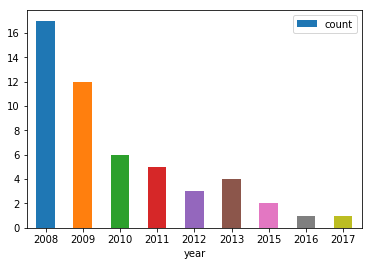

In [76]:
# Violations in the state of NY between 2008 and 2018 for contaminants copper and lead
contaminant_codes = [1022, 1030]
df = get_num_violations(water_sys_viol, 'NY', 2008, 2018, contaminant_codes)
s1 = df.size()

if len(s1.index) > 0:
    df3 = pd.DataFrame({'year': s1.index, 'count': s1.values})
    ax = df3.plot.bar(x='year', y='count', rot=0)
else:
    print ('No data to chart')

## Dictionary of contaminant codes

In [73]:
drinking_water_regs = pd.read_csv(os.path.join(epa_dir, 'drinking-water-regulations.csv'), sep=',', \
                                 dtype={'SDWIS_CONTAMINANT_CODE': np.str})
drinking_water_regs.head()

,CONTAMINANT,SDWIS_CONTAMINANT_CODE,TYPE,MCL_GOAL,MCL_OR_TT,POTENTIAL_HEALTH_EFFECTS,SOURCES_OF_CONTAMINANT_IN_DRINKING_WATER
0,Cryptosporidium,2078,Microorganisms,zero,TT3,"Gastrointestinal illness (such as diarrhea, vo...",Human and animal fecal waste
1,Giardia lamblia,3008,Microorganisms,zero,TT3,"Gastrointestinal illness (such as diarrhea, vo...",Human and animal fecal waste
2,Heterotrophic plate count (HPC),3001,Microorganisms,NaN,TT3,HPC has no health effects; it is an analytic m...,HPC measures a range of bacteria that are natu...
3,Legionella,3012,Microorganisms,zero,TT3,"Legionnaire's Disease, a type of pneumonia",Found naturally in water; multiplies in heatin...
4,Total Coliforms (including fecal coliform and ...,3100,Microorganisms,zero,5.0%4,Not a health threat in itself; it is used to i...,Coliforms are naturally present in the environ...
